# Cleaning and smoothing trajectory data with moving pandas

In [1]:
import movingpandas as mpd
import geopandas as gpd
import pandas as pd
from datetime import datetime, timedelta
from shapely.geometry import LineString, Point
from shapely.wkt import loads
import matplotlib.pyplot as plt
import os
from srai.regionalizers import geocode_to_region_gdf
from srai.datasets import AirbnbMulticityDataset
from srai.embedders import Hex2VecEmbedder
from srai.joiners import IntersectionJoiner
from srai.loaders.osm_loaders import OSMPbfLoader
from srai.loaders.osm_loaders.filters import HEX2VEC_FILTER
from srai.neighbourhoods.h3_neighbourhood import H3Neighbourhood
from srai.plotting import plot_regions
from srai.regionalizers import H3Regionalizer
import warnings
import torch
import pyarrow.feather as feather
from geopy.distance import geodesic
import seaborn as sns
import numpy as np

In [2]:
def plot_trajectories(gdf, title="", save=False, grouped=True):
    # only geometry column 
    gdf = gdf[['geometry', 'trajectory_id']]
    print("Plotting")
    # if not grouped:
    #     gdf_group = gdf.groupby('trajectory_id').agg(
    #         {'geometry': LineString,
    #          'trajectory_id': 'first'})
    #     gdf = gpd.GeoDataFrame(gdf_group, geometry='geometry', crs='32650')
    gdf.plot(figsize=(20, 10), alpha=0.5, edgecolor='k')
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    if save:
        plt.savefig(os.path.join('figures', f'{title}.png'))
    plt.show()

In [3]:
hvplot_defaults = {'tiles':'CartoLight', 'frame_height':320, 'frame_width':320, 'cmap':'Viridis', 'colorbar':True}
kwargs = {**hvplot_defaults, 'c':'speed', 'line_width':7}

# Load raw data

In [ ]:
gdf = gpd.read_parquet(os.path.join('output_data', 'geolife.parquet'))

In [ ]:
gdf['time'] = pd.to_datetime(gdf['time'])
gdf.crs = 'EPSG:4326'

In [ ]:
gdf.head()

In [ ]:
gdf.shape

In [ ]:
def validate_cords(gdf, lon_col='longitude', lat_col='latitude', trip_id_col='trajectory_id'):
    valid_lon = (-180 <= gdf[lon_col]) & (gdf[lon_col] <= 180)
    valid_lat = (-90 <= gdf[lat_col]) & (gdf[lat_col] <= 90)
    
    valid_coords = valid_lon & valid_lat
    
    invalid_trip_ids = gdf.loc[~valid_coords, trip_id_col].unique()
    
    gdf = gdf[~gdf[trip_id_col].isin(invalid_trip_ids)]
    
    return gdf

In [8]:
gdf = validate_cords(gdf)

In [9]:
pekin_area = geocode_to_region_gdf("Pekin, China")

In [10]:
gdf_pekin = gdf.sjoin(pekin_area)

In [11]:
gdf_pekin.shape

(19880914, 11)

In [12]:
gdf_merged = gdf.merge(gdf_pekin, how="left", indicator=True)

In [13]:
gdf_outside_pekin = gdf_merged[gdf_merged["_merge"] == "left_only"]

In [14]:
traj_outside_pekin = list(gdf_outside_pekin["trajectory_id"].unique())

In [15]:
gdf_pekin = gdf_pekin[~gdf_pekin["trajectory_id"].isin(traj_outside_pekin)]

In [16]:
gdf_pekin.to_parquet(os.path.join('output_data', 'geolife_pekin.parquet'))

# Load ready geoliefe Pekin

In [4]:
gdf_pekin = gpd.read_parquet(os.path.join('output_data', 'geolife_pekin.parquet'))

In [5]:
gdf_pekin = gdf_pekin.to_crs(epsg=32650)

In [6]:
gdf_pekin.head()

,latitude,longitude,altitude,date,date_str,time,trajectory_id,mode,geometry,user_id,index_right
0,39.974294,116.399741,492.0,39816.056644,2009-01-03,2009-01-03 01:21:34,20090103012134,unknown,POINT (448742.698 4425076.609),135,"Beijing, China"
1,39.974292,116.399592,492.0,39816.056655,2009-01-03,2009-01-03 01:21:35,20090103012134,unknown,POINT (448729.973 4425076.473),135,"Beijing, China"
2,39.974309,116.399523,492.0,39816.056667,2009-01-03,2009-01-03 01:21:36,20090103012134,unknown,POINT (448724.094 4425078.399),135,"Beijing, China"
3,39.974320,116.399588,492.0,39816.056690,2009-01-03,2009-01-03 01:21:38,20090103012134,unknown,POINT (448729.653 4425079.583),135,"Beijing, China"
4,39.974365,116.399730,491.0,39816.056701,2009-01-03,2009-01-03 01:21:39,20090103012134,unknown,POINT (448741.812 4425084.496),135,"Beijing, China"


# Group Pekin

In [7]:
gdf_pekin_group = gdf_pekin.groupby('trajectory_id').agg(
    {'geometry': LineString, 'time': list, 'altitude': list,
     'trajectory_id': 'first'})

In [8]:
gdf_pekin_group = gpd.GeoDataFrame(gdf_pekin_group, geometry='geometry', crs='32650')

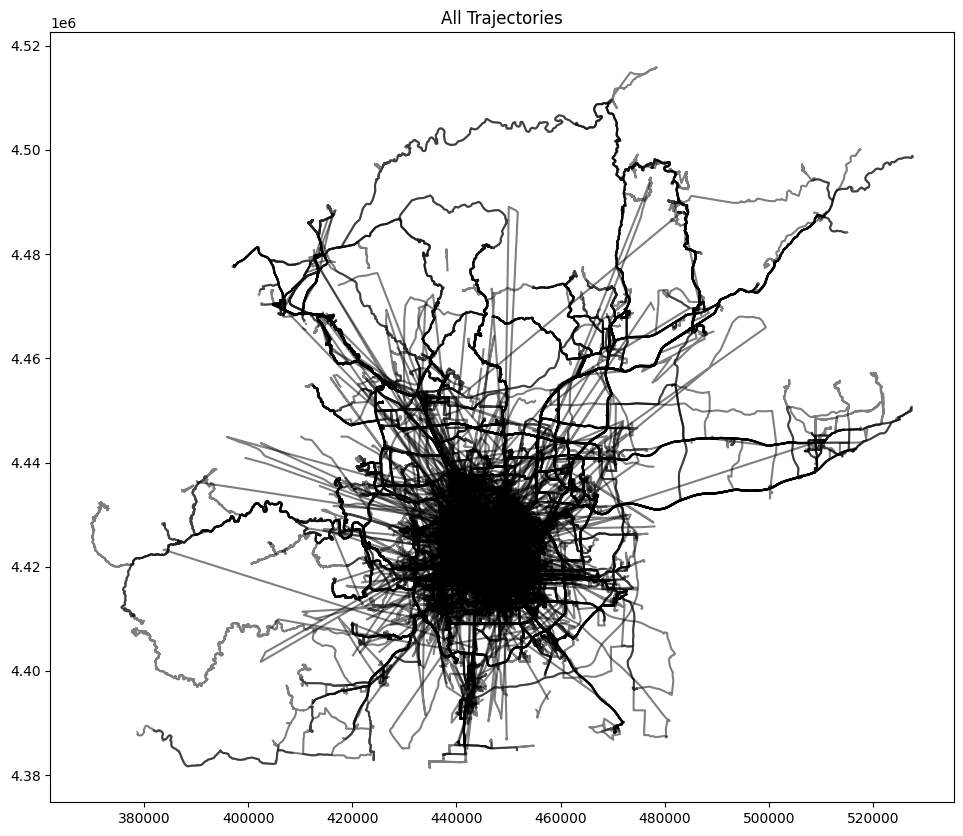

In [9]:
gdf_pekin_group.plot(figsize=(20, 10), alpha=0.5, edgecolor='k')
plt.title('All Trajectories')
plt.show()

In [10]:
gdf_pekin_group.head()

,geometry,time,altitude,trajectory_id
trajectory_id,,,,
20000101231219,"LINESTRING (442545.429 4426752.285, 442548.618...","[2000-01-01 23:12:19, 2000-01-01 23:13:21, 200...","[128.937004593176, 221.128615485564, 217.19159...",20000101231219
20070412093132,"LINESTRING (442820.014 4425112.043, 442825.777...","[2007-04-12 09:31:32, 2007-04-12 09:39:37, 200...","[823.490813648294, 823.490813648294, 741.46981...",20070412093132
20070412101853,"LINESTRING (442812.545 4425254.546, 442822.785...","[2007-04-12 10:18:53, 2007-04-12 10:20:15, 200...","[351.049868766404, 114.829396325459, 114.82939...",20070412101853
20070412102116,"LINESTRING (442794.835 4425360.126, 442801.896...","[2007-04-12 10:21:16, 2007-04-12 10:21:22, 200...","[173.884514435696, 173.884514435696, 173.88451...",20070412102116
20070412102325,"LINESTRING (442822.785 4425291.468, 442828.589...","[2007-04-12 10:23:25, 2007-04-12 10:24:37, 200...","[114.829396325459, 114.829396325459, 118.11023...",20070412102325


# Outliers

In [29]:
def calculate_projected_distance(point1, point2):
    return np.sqrt((point1.x - point2.x)**2 + (point1.y - point2.y)**2)

def contains_outlier(line, threshold):
    coords = list(line.coords)
    for i in range(1, len(coords)):
        point1 = Point(coords[i-1])
        point2 = Point(coords[i])
        if calculate_projected_distance(point1, point2) > threshold:
            return True
    return False

def filter_trajectories(gdf, threshold):
    return gdf[~gdf['geometry'].apply(lambda geom: contains_outlier(geom, threshold))]

def plot_threshold_vs_trajectory_count(gdf, thresholds):
    counts = []
    for threshold in thresholds:
        filtered_gdf = filter_trajectories(gdf, threshold)
        counts.append(len(filtered_gdf))

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, counts, marker='o')
    plt.xlabel('Distance Threshold (meters)')
    plt.ylabel('Number of Trajectories')
    plt.title('Number of Trajectories vs. Distance Threshold')
    plt.grid(True)
    plt.xticks(np.arange(min(thresholds), max(thresholds) + 500, 500))
    plt.show()

In [43]:
thresholds = np.arange(1000, 7001, 1000)

plot_threshold_vs_trajectory_count(gdf_pekin_group, thresholds)

KeyboardInterrupt: 

In [80]:
distance_threshold = 2000

In [81]:
gdf_pekin_group['contains_outlier'] = gdf_pekin_group['geometry'].apply(lambda line: contains_outlier(line, distance_threshold))

In [82]:
clean_gdf_pekin_group = gdf_pekin_group[~gdf_pekin_group['contains_outlier']]

print(f"Liczba trajektorii przed czyszczeniem: {len(gdf_pekin_group)}")
print(f"Liczba trajektorii po czyszczeniu: {len(clean_gdf_pekin_group)}") # 14422

Liczba trajektorii przed czyszczeniem: 16122
Liczba trajektorii po czyszczeniu: 13332


In [83]:
clean_gdf_pekin_group.reset_index(drop=True, inplace=True)

In [84]:
clean_gdf_pekin_group.head()

,geometry,time,altitude,trajectory_id,contains_outlier
0,"LINESTRING (442545.429 4426752.285, 442548.618...","[2000-01-01 23:12:19, 2000-01-01 23:13:21, 200...","[128.937004593176, 221.128615485564, 217.19159...",20000101231219,False
1,"LINESTRING (442820.014 4425112.043, 442825.777...","[2007-04-12 09:31:32, 2007-04-12 09:39:37, 200...","[823.490813648294, 823.490813648294, 741.46981...",20070412093132,False
2,"LINESTRING (442812.545 4425254.546, 442822.785...","[2007-04-12 10:18:53, 2007-04-12 10:20:15, 200...","[351.049868766404, 114.829396325459, 114.82939...",20070412101853,False
3,"LINESTRING (442794.835 4425360.126, 442801.896...","[2007-04-12 10:21:16, 2007-04-12 10:21:22, 200...","[173.884514435696, 173.884514435696, 173.88451...",20070412102116,False
4,"LINESTRING (442822.785 4425291.468, 442828.589...","[2007-04-12 10:23:25, 2007-04-12 10:24:37, 200...","[114.829396325459, 114.829396325459, 118.11023...",20070412102325,False


Plotting


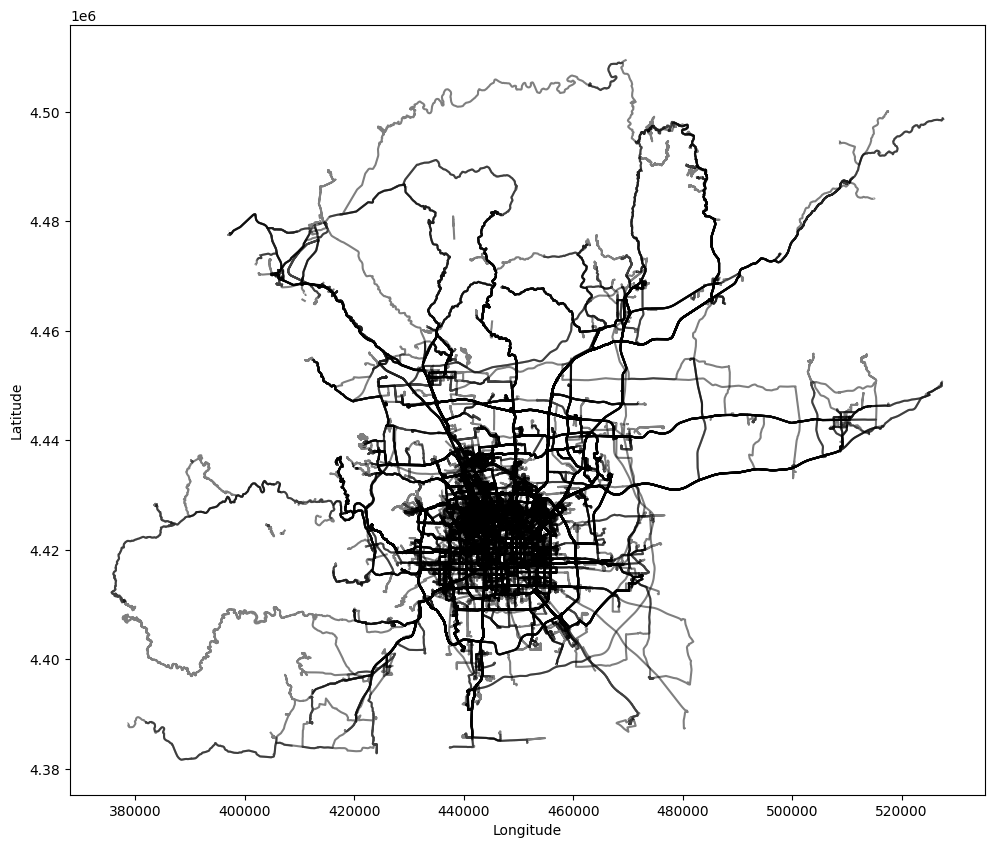

In [85]:
plot_trajectories(clean_gdf_pekin_group)

In [86]:
clean_gdf_pekin_group.to_parquet(os.path.join('output_data', 'geolife_pekin_clean_small.parquet'))

# TrajectoryCollection

In [11]:
traj_col = mpd.TrajectoryCollection(gdf_pekin,'trajectory_id', t = 'time', x = 'latitude', y = 'longitude', crs = 'epsg:32650')

In [12]:
traj_col.add_speed(units=("km", "h"), overwrite = True)

In [13]:
results = traj_col.to_point_gdf()

In [14]:
results.sort_values('speed', ascending=False)

,latitude,longitude,altitude,date,date_str,trajectory_id,mode,geometry,user_id,index_right,speed
time,,,,,,,,,,,
2008-10-30 08:37:17,39.984913,116.483635,144.4,39751.359225,2008-10-30,20081030083451,unknown,POINT (455913.426 4426210.403),128,"Beijing, China",53444.914758
2008-10-30 08:37:19,39.984935,116.483635,147.6,39751.359248,2008-10-30,20081030083451,unknown,POINT (455913.440 4426212.811),128,"Beijing, China",53433.801857
2008-10-30 08:37:18,39.974957,116.310292,118.1,39751.359236,2008-10-30,20081030083451,unknown,POINT (441104.945 4425205.395),062,"Beijing, China",53433.163961
2008-10-30 08:37:20,39.974950,116.310345,118.1,39751.359259,2008-10-30,20081030083451,unknown,POINT (441109.491 4425204.616),062,"Beijing, China",53417.665731
2008-10-30 08:37:21,39.984982,116.483630,144.4,39751.359271,2008-10-30,20081030083451,unknown,POINT (455913.052 4426217.986),128,"Beijing, China",53417.539706
...,...,...,...,...,...,...,...,...,...,...,...
2009-08-08 10:51:25,40.022017,116.368069,107.0,40033.452373,2009-08-08,20090808060826,unknown,POINT (446075.697 4430392.135),144,"Beijing, China",0.000000
2009-05-06 06:18:07,40.100088,116.545578,98.4,39939.262581,2009-05-06,20090506022219,unknown,POINT (461267.323 4438965.074),042,"Beijing, China",0.000000
2009-05-06 06:18:03,40.100088,116.545578,98.4,39939.262535,2009-05-06,20090506022219,unknown,POINT (461267.323 4438965.074),042,"Beijing, China",0.000000


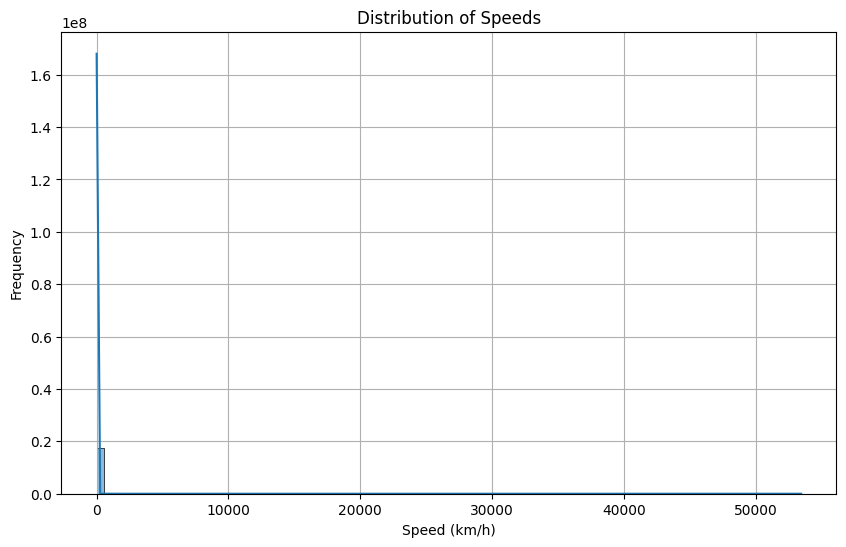

In [21]:
# Ekstrakcja prędkości
speeds = results['speed'].dropna()

# Tworzenie wykresu rozkładu prędkości
plt.figure(figsize=(10, 6))
sns.histplot(speeds, bins=100, kde=True)
plt.title('Distribution of Speeds')
plt.xlabel('Speed (km/h)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [17]:
traj_col.trajectories[4432].hvplot(**kwargs)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]   (speed)
   .Points.I :Points   [Longitude,Latitude]   (speed,triangle_angle)

# Spatial Embedding

In [4]:
HEX_RES = 10

In [6]:
regionalizer = H3Regionalizer(resolution=HEX_RES)
regions = regionalizer.transform(pekin_area)

In [7]:
loader = OSMPbfLoader()
features = loader.load(regions, HEX2VEC_FILTER)

/Users/szymonleszkiewicz/anaconda3/envs/obsrai/lib/python3.10/site-packages/quackosm/osm_extracts/__init__.py:498: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  ].unary_union


In [8]:
joiner = IntersectionJoiner()
joint = joiner.transform(regions, features)

In [10]:
regions.to_feather(os.path.join('temp', f'regions_{HEX_RES}.feather'))
features.to_feather(os.path.join('temp', f'features_{HEX_RES}.feather'))
joint.to_feather(os.path.join('temp', f'joint_{HEX_RES}.feather'))

In [18]:
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
neighbourhood = H3Neighbourhood(regions)
embedder_hidden_sizes = [150, 100, 50, 10]
embedder = Hex2VecEmbedder(embedder_hidden_sizes)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    embeddings = embedder.fit_transform(
        regions,
        features,
        joint,
        neighbourhood,
        trainer_kwargs={"max_epochs": 15, "accelerator": device},
        batch_size=100,
    )

In [ ]:
embeddings.to_parquet(os.path.join('output_data', f'embeddings_{HEX_RES}.parquet'))

# CLEAN

### max speed

In [15]:
cleaned_max = mpd.OutlierCleaner(traj_col).clean(
    v_max=300, units=("km", "h")
)

In [16]:
cleaned_max_gdf = cleaned_max.to_point_gdf()

In [18]:
traj_col.filter(max_speed=300)

TypeError: TrajectoryCollection.filter() got an unexpected keyword argument 'max_speed'

In [17]:
cleaned_max_gdf.sort_values('speed', ascending=False)

,latitude,longitude,altitude,date,date_str,trajectory_id,mode,geometry,user_id,index_right,speed
time,,,,,,,,,,,
2008-10-30 08:37:18,39.974957,116.310292,118.1,39751.359236,2008-10-30,20081030083451,unknown,POINT (441104.945 4425205.395),062,"Beijing, China",53433.163961
2008-10-30 08:37:20,39.974950,116.310345,118.1,39751.359259,2008-10-30,20081030083451,unknown,POINT (441109.491 4425204.616),062,"Beijing, China",53417.665731
2008-10-30 08:36:04,39.974995,116.310375,114.8,39751.358380,2008-10-30,20081030083451,unknown,POINT (441112.100 4425209.602),062,"Beijing, China",53401.603271
2008-10-30 08:36:02,39.975003,116.310393,114.8,39751.358356,2008-10-30,20081030083451,unknown,POINT (441113.669 4425210.511),062,"Beijing, China",53396.084034
2008-10-30 08:37:22,39.974958,116.310420,118.1,39751.359282,2008-10-30,20081030083451,unknown,POINT (441115.902 4425205.499),062,"Beijing, China",53394.294788
...,...,...,...,...,...,...,...,...,...,...,...
2009-06-09 09:42:42,40.010504,116.322369,217.0,39973.404653,2009-06-09,20090609002030,unknown,POINT (442166.249 4429142.946),003,"Beijing, China",0.000000
2008-05-22 04:13:11,39.981425,116.328058,175.0,39590.175822,2008-05-22,20080521225759,unknown,POINT (442627.462 4425911.748),085,"Beijing, China",0.000000
2009-06-09 09:42:07,40.010417,116.322087,208.0,39973.404248,2009-06-09,20090609002030,unknown,POINT (442142.107 4429133.473),000,"Beijing, China",0.000000


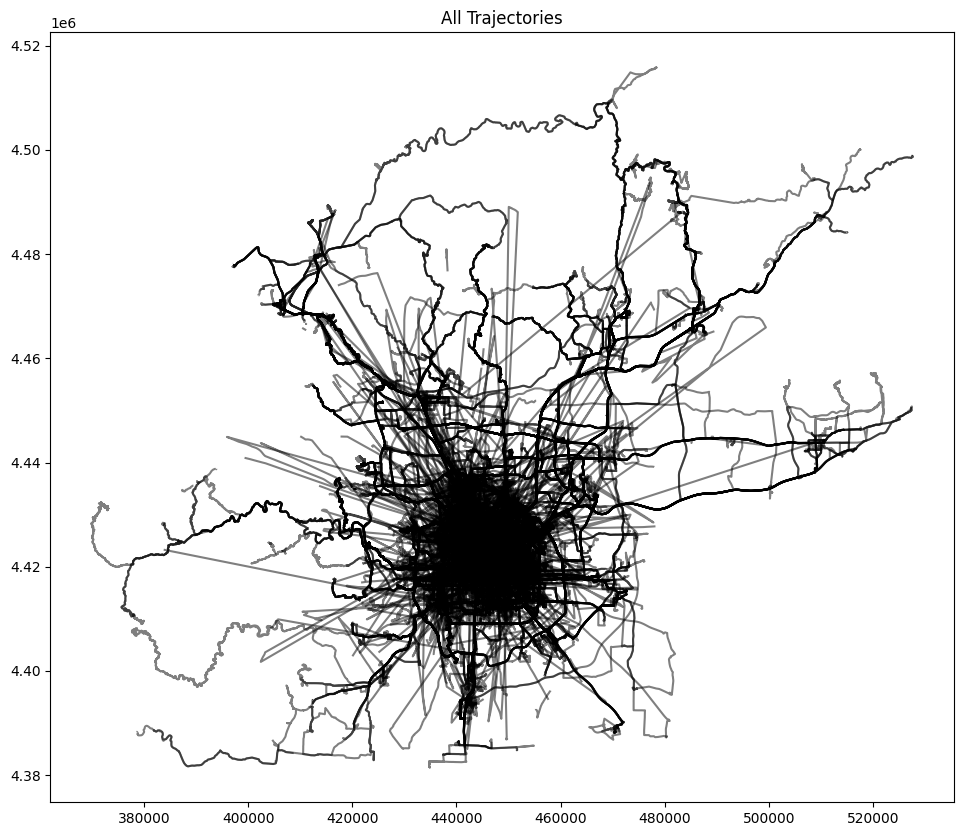

In [39]:
plot_trajectories(cleaned_max_gdf)

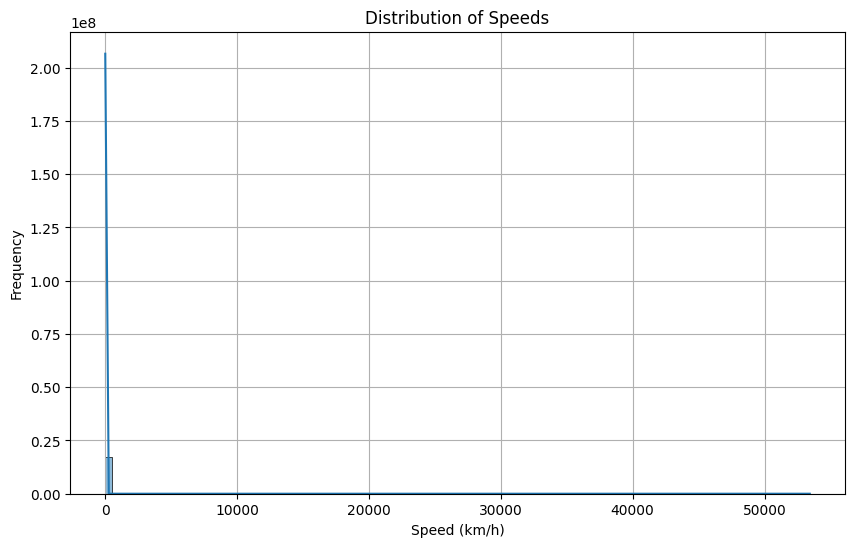

In [41]:
# Ekstrakcja prędkości
speeds_cleaned = cleaned_max_gdf['speed'].dropna()

# Tworzenie wykresu rozkładu prędkości
plt.figure(figsize=(10, 6))
sns.histplot(speeds_cleaned, bins=100, kde=True)
plt.title('Distribution of Speeds')
plt.xlabel('Speed (km/h)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [46]:
cleaned_max.trajectories[13].hvplot(**kwargs)+traj_col.trajectories[13].hvplot(**kwargs)

:Layout
   .Overlay.I  :Overlay
      .WMTS.I   :WMTS   [Longitude,Latitude]
      .Path.I   :Path   [Longitude,Latitude]   (speed)
      .Points.I :Points   [Longitude,Latitude]   (speed,triangle_angle)
   .Overlay.II :Overlay
      .WMTS.I   :WMTS   [Longitude,Latitude]
      .Path.I   :Path   [Longitude,Latitude]   (speed)
      .Points.I :Points   [Longitude,Latitude]   (speed,triangle_angle)

### alpha

In [47]:
cleaned_alpha = mpd.OutlierCleaner(traj_col).clean(alpha = 1.0)

In [48]:
cleaned_alpha_gdf = cleaned_alpha.to_point_gdf()

In [49]:
cleaned_alpha_gdf.sort_values('speed', ascending=False)

,latitude,longitude,altitude,date,date_str,trajectory_id,mode,geometry,user_id,index_right,speed
time,,,,,,,,,,,
2008-10-30 08:37:18,39.974957,116.310292,118.1,39751.359236,2008-10-30,20081030083451,unknown,POINT (441104.945 4425205.395),062,"Beijing, China",14842.545545
2008-10-30 08:37:20,39.974950,116.310345,118.1,39751.359259,2008-10-30,20081030083451,unknown,POINT (441109.491 4425204.616),062,"Beijing, China",14838.240481
2008-10-30 08:36:04,39.974995,116.310375,114.8,39751.358380,2008-10-30,20081030083451,unknown,POINT (441112.100 4425209.602),062,"Beijing, China",14833.778686
2008-10-30 08:36:02,39.975003,116.310393,114.8,39751.358356,2008-10-30,20081030083451,unknown,POINT (441113.669 4425210.511),062,"Beijing, China",14832.245565
2008-10-30 08:37:22,39.974958,116.310420,118.1,39751.359282,2008-10-30,20081030083451,unknown,POINT (441115.902 4425205.499),062,"Beijing, China",14831.748552
...,...,...,...,...,...,...,...,...,...,...,...
2008-11-26 03:06:14,39.999982,116.327513,210.0,39778.129329,2008-11-26,20081125222634,unknown,POINT (442596.465 4427971.766),005,"Beijing, China",0.000000
2008-11-26 03:06:29,39.999946,116.327519,211.0,39778.129502,2008-11-26,20081125222634,unknown,POINT (442596.947 4427967.766),005,"Beijing, China",0.000000
2008-11-26 03:06:59,39.999912,116.327279,196.0,39778.129850,2008-11-26,20081125222634,unknown,POINT (442576.432 4427964.147),005,"Beijing, China",0.000000


In [50]:
plot_trajectories(cleaned_alpha_gdf)

GEOSException: IllegalArgumentException: point array must contain 0 or >1 elements


In [25]:
cleaned_alpha.trajectories[12].hvplot(**kwargs)+traj_col.trajectories[12].hvplot(**kwargs)

:Layout
   .Overlay.I  :Overlay
      .WMTS.I   :WMTS   [Longitude,Latitude]
      .Path.I   :Path   [Longitude,Latitude]   (speed)
      .Points.I :Points   [Longitude,Latitude]   (speed,triangle_angle)
   .Overlay.II :Overlay
      .WMTS.I   :WMTS   [Longitude,Latitude]
      .Path.I   :Path   [Longitude,Latitude]   (speed)
      .Points.I :Points   [Longitude,Latitude]   (speed,triangle_angle)

## SAVE

In [35]:
if not os.path.exists('output_data'):
    os.makedirs('output_data')

In [ ]:
# save cleaned_alpha and cleaned_max to point gdf and file
cleaned_max_gdf = cleaned_max.to_point_gdf()
cleaned_max_gdf.to_parquet(os.path.join('output_data', 'geolife_max.parquet'))

In [ ]:
cleaned_alpha_gdf = cleaned_alpha.to_point_gdf()
cleaned_alpha_gdf.to_parquet(os.path.join('output_data', 'geolife_alpha.parquet'))

### filter short trajectories

In [26]:
filtered_trajectory_collection = [
    trajectory
    for trajectory in cleaned_alpha.trajectories
    if trajectory.size() >= 10
]

In [30]:
cleaned = mpd.TrajectoryCollection(filtered_trajectory_collection)

# [Generalization](https://movingpandas.github.io/movingpandas-website/1-tutorials/7-generalizing-trajectories.html)

In [20]:
test = traj_col.trajectories[12] # 12 13
test.hvplot(**kwargs)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]   (speed)
   .Points.I :Points   [Longitude,Latitude]   (speed,triangle_angle)

In [ ]:
test

In [31]:
traj_col_dp = mpd.DouglasPeuckerGeneralizer(cleaned).generalize(tolerance=0.0001)

In [32]:
results_dp = traj_col_dp.to_point_gdf()
results_dp.shape

(1199437, 11)

In [ ]:
i = 312
traj_col_dp.trajectories[i].hvplot(**kwargs)+traj_col.trajectories[i].hvplot(**kwargs)

# SMOOTH

In [ ]:
# smooth = mpd.KalmanSmootherCV(cleaned).smooth(process_noise_std=0.1, measurement_noise_std=10)
# smooth

In [ ]:
# smooth.trajectories[i].hvplot(**kwargs)+traj_col_dp.trajectories[i].hvplot(**kwargs)

In [33]:
smooth2 = mpd.KalmanSmootherCV(traj_col_dp).smooth(process_noise_std=0.1, measurement_noise_std=2)
smooth2

TrajectoryCollection with 15794 trajectories

In [ ]:
smooth.trajectories[i].hvplot(**kwargs)+smooth2.trajectories[i].hvplot(**kwargs)+traj_col_dp.trajectories[i].hvplot(**kwargs)

In [ ]:
i = 1645
smooth.trajectories[i].hvplot(**kwargs)+smooth2.trajectories[i].hvplot(**kwargs)+traj_col_dp.trajectories[i].hvplot(**kwargs)

In [34]:
smooth2_gdf = smooth2.to_point_gdf()
smooth2_gdf.shape

(1199437, 11)

In [35]:
if not os.path.exists('output_data'):
    os.makedirs('output_data')
smooth2_gdf.to_parquet(os.path.join('output_data', 'geolife_mpd2.parquet'))